In [2]:
from joblib import dump, load
import numpy as np
import cv2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
#import the clustered ds swatches
hsv_knn = load('ds_h_knn_3.joblib')

# Validation steps
1. import an image made from five swatches of ds paints
2. collect the hsv and shifted HSV values
3. Drop the neutral tones
4. Cluster on K-means++ and collect the top 5 clusters
5. Match those clusters to the hsv_knn model

## Import the test image
goldfinch

In [53]:
img = cv2.imread('/Users/macbook/Box/insight_project_data/test_image/arrow.jpg')

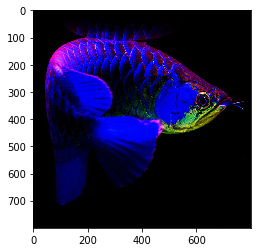

In [54]:
#don't forget it is in brg
plt.imshow(img)

In [55]:
#convert to hsv
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


In [56]:
#convert to pixels
pixels = np.float32(img_HSV.reshape(-1, 3))

In [57]:
def shift_h_remove(data, v_thresh, s_thresh):
    """Produces shifted H values for color segmentation and removed neutral tones
    Inputs: data - list of pixel H, S, V values one entry per pixel
    Outputs: H, H120, H240
    """
    shifted_colors = []
    for i in range(0,len(data)):
        H = data[i][0]
        s = data[i][1]
        v = data[i][2]
        V_thres = 255*v_thresh
        S_thres = 255*s_thresh
        if (v > V_thres and s > S_thres):
            if H >= 120:
                H120 = H - 120
            else:
                H120 = H + 60
            if H >= 60:
                H240 = H - 60
            else:
                H240 = H + 120
            shifted_colors.append([H, H120, H240, s, v])        
        else:
           pass
        
        
    return shifted_colors

In [58]:
pixels_shift = shift_h_remove(pixels, .25, .25)

In [59]:
pixels_shift[0]

[178.0, 58.0, 118.0, 251.0, 72.0]

In [60]:
len(pixels)

640000

In [61]:
len(pixels_shift)

170667

In [62]:
pixels_df = pd.DataFrame(pixels_shift, columns=['h','H120','H240','s','v'])

In [63]:
X_pixels = pixels_df[['h']]

In [64]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42, algorithm = 'full')
kmeans.fit(X_pixels)
image2show = kmeans.cluster_centers_[kmeans.labels_]

In [65]:
kmeans_df = pd.DataFrame(image2show, columns=['h'])

In [66]:
kmeans_df['label'] = kmeans.labels_

In [67]:
kmeans_df.groupby('label').mean()

,h
label,
0,0.457248
1,164.049521
2,74.027360
3,128.127654
4,176.451266
5,147.426552
6,46.738283
7,92.389786


In [68]:
kmeans_df.label.value_counts()

0    97306
4    29220
1    19204
5    10470
7     4210
2     4057
3     3533
6     2667
Name: label, dtype: int64

In [69]:
kmeans_top = kmeans_df[(kmeans_df['label'] == 5) | (kmeans_df['label'] == 14)| (kmeans_df['label'] == 0)| (kmeans_df['label'] == 17)| (kmeans_df['label'] == 16)| (kmeans_df['label'] == 3)| (kmeans_df['label'] == 11)| (kmeans_df['label'] == 12)| (kmeans_df['label'] == 8)]

In [70]:
kmeans_top.label.value_counts()

0    97306
5    10470
3     3533
Name: label, dtype: int64

In [71]:
X = kmeans_df[['h']]

In [72]:
predict_colors = hsv_knn.predict(X)

In [73]:
colors2 = np.array(np.unique(predict_colors, return_counts=True)).T

In [74]:
colors2

array([['Carbazole Violet', 10470],
       ['Imperial Purple', 3533],
       ['Manganese Blue Hue', 4210],
       ['Phthalo Green Blue Shade', 4057],
       ['Quinacridone Coral', 97306],
       ['Quinacridone Purple', 19204],
       ['Quinacridone Red', 29220],
       ['Sap Green', 2667]], dtype=object)

In [75]:
colors2df = pd.DataFrame(colors2, columns = ['name', 'count'])

In [76]:
colors2df.sort_values(by=['count'], ascending = False)

,name,count
4,Quinacridone Coral,97306
6,Quinacridone Red,29220
5,Quinacridone Purple,19204
0,Carbazole Violet,10470
2,Manganese Blue Hue,4210
3,Phthalo Green Blue Shade,4057
1,Imperial Purple,3533
7,Sap Green,2667


In [77]:
kmeans.cluster_centers_

array([[  0.45724827],
       [164.04952093],
       [ 74.02736012],
       [128.12765355],
       [176.45126626],
       [147.42655205],
       [ 46.73828271],
       [ 92.38978622]])

In [78]:
colors = np.array(np.unique(kmeans.labels_, return_counts=True)).T
print(colors)

[[    0 97306]
 [    1 19204]
 [    2  4057]
 [    3  3533]
 [    4 29220]
 [    5 10470]
 [    6  2667]
 [    7  4210]]


In [79]:
kmeans.labels_

array([4, 0, 0, ..., 4, 4, 4], dtype=int32)

# Start HERE

In [327]:
hsv_knn2 = load('ds_h_knn_2.joblib')

In [80]:
predict_colors = hsv_knn.predict(X_pixels)

In [81]:
predict_colors

array(['Alizarin Crimson', 'Cadmium Red Medium Hue',
       'Cadmium Red Medium Hue', ..., 'Permanent Alizarin Crimson',
       'Permanent Alizarin Crimson', 'Permanent Alizarin Crimson'],
      dtype=object)

In [82]:
colors = np.array(np.unique(predict_colors, return_counts=True)).T

In [83]:
colors

array([['Alizarin Crimson', 6833],
       ['Bismuth Vanadate Yellow', 17],
       ['Burnt Umber', 95],
       ['Cadmium Red Medium Hue', 80715],
       ['Cadmium Yellow Light Hue', 48],
       ['Cadmium Yellow Medium Hue', 84],
       ['Carbazole Violet', 6687],
       ['Cascade Green', 1207],
       ['Cerulean Blue', 86],
       ['Cerulean Blue Chromium', 405],
       ['Cobalt Blue', 284],
       ['Cobalt Violet', 3219],
       ['French Ultramarine', 147],
       ['Green Gold', 63],
       ['Hansa Yellow Medium', 29],
       ['Hooker’s Green', 1188],
       ['Imperial Purple', 3252],
       ['Indian Yellow', 68],
       ['Manganese Blue Hue', 1379],
       ['Moonglow', 1618],
       ['Naples Yellow', 48],
       ['Nickel Azo Yellow', 48],
       ['Opera Pink', 1545],
       ['Organic Vermilion', 640],
       ['Perinone Orange', 114],
       ['Permanent Alizarin Crimson', 12450],
       ['Phthalo Blue Green Shade', 105],
       ['Phthalo Blue Red Shade', 314],
       ['Phthalo Green Bl

In [84]:
predictions = pd.DataFrame(colors, columns=["name","pixels"])

In [85]:
predictions.sort_values(by=['pixels'], ascending = False)

,name,pixels
3,Cadmium Red Medium Hue,80715
25,Permanent Alizarin Crimson,12450
36,Quinacridone Coral,11052
39,Quinacridone Magenta,7419
0,Alizarin Crimson,6833
6,Carbazole Violet,6687
41,Quinacridone Red,5465
40,Quinacridone Purple,3857
44,Quinacridone Violet,3511
16,Imperial Purple,3252
